# HW 2.1 Latent "Purposes" in Mobile Apps [50 + 10 points]

   * Dataset and updates: https://gist.github.com/emaadmanzoor/aedddf2b69e54a9a2fd320230bbb692a
   * Contact TA: Emaad Ahmed Manzoor (emaad[at]cmu.edu)

*Please only attempt bonus point problems after completing the non-bonus questions.*

We hypothesize the existence of latent "purposes" manifested by mobile phone applications; a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/)).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.
   * Play with the data to understand what each column may mean.

In [2]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [3]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [4]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


Note that the permissions are tagged with a category that describes them (for example, "system tools"). This will help us interpret them later

## Apps as documents

One approach to model apps as documents is to use their "description" field directly.

A less conventional approach is to exploit the fact that the permissions an app requests as direct evidence about what it's really trying to do. Think of app purposes as "topics", and each app as a "document" where its requested permissions are "words".

### Convert each app into a "document" [2.5 points]

   * Create a new dataframe by filtering out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix (see `as_matrix()` in Pandas).
   * You should have a (180295, 173) shape numpy matrix X containing only 0s and 1s.
   
X is now your "document" or "word-frequency" matrix.

In [5]:
permission_columns = list(df.columns[10:])
df_perms = df[permission_columns]
df_perms.head()
X = df_perms.as_matrix()

### Downweight "stop-words" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
df_tfidf = TfidfTransformer().fit_transform(X)

### Discover "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine.
   * This may take around 3 minutes to run. Test on a sample first.

In [7]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                learning_method='online',
                                n_jobs=-1)
lda.fit(df_tfidf)

CPU times: user 23.4 s, sys: 1.03 s, total: 24.4 s
Wall time: 2min 45s


Now each app can be viewed as a distribution over these 20 topics, and each topic is a distribution over all the permissions in the data.

### List the top 10 "words" in each topic [10 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

*Interpetations may be subjective and differ.*

*I have listed the top 5 words below, the code for 10 is identical with `n_top_words` is changed to 10*

In [8]:
n_top_words = 5
feature_names = df_perms.columns
most_probable_words = []
for topic_idx, topic in enumerate(lda.components_):
    message = "Topic #%d: " % topic_idx
    message += "\n\t"
    message += "\n\t".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words-1:-1]])
    most_probable_words.append("\n\t".join([feature_names[i]
                                           for i in topic.argsort()[:-n_top_words-1:-1]]))
    print(message)
    print()

Topic #0: 
	Network communication : view network state (S)
	Network communication : full Internet access (D)
	Hardware controls : control vibrator (S)
	Services that cost you money : directly call phone numbers (D)
	System tools : change your UI settings (D)

Topic #1: 
	System tools : modify global system settings (D)
	Storage : modify/delete USB storage contents modify/delete SD card contents (D)
	System tools : display system-level alerts (D)
	Network communication : full Internet access (D)
	Network communication : view network state (S)

Topic #2: 
	Your accounts : discover known accounts (S)
	System tools : kill background processes (S)
	System tools : change your UI settings (D)
	Your accounts : access other Google services (D)
	Default : directly install applications (S)

Topic #3: 
	Storage : modify/delete USB storage contents modify/delete SD card contents (D)
	Network communication : full Internet access (D)
	Your location : coarse (network-based) location (D)
	Network commu

### For each topic, list the top 3 apps with the highest probability assigned to that topic [10 points]

This further helps us understand what the topics actually mean. Go back and revise your list of topic interpretations after this: what kind of apps is each topic most likely to contain?

   * Transform the TF-IDF matrix into a matrix of topic proportions for each app; each row corresponds to one app. Consider the `transform` function of the LDA model you just fit. Now your data has been reduced to a dimensionality of just 20.


   * For each column i in 0...19:
      - Sort the rows in the topic proportion matrix by column i (topic i). Consider using `np.argsort` to obtain the sorted indices. The indices correspond to the position each row should be moved to, to obtain the rows sorted in increasing order by column i.
      - Create a new "temp" column in the original dataframe with these indices.
      - Sort the original dataframe in descending order by these indices.
      - Print the names of the top 3 apps in the sorted dataframe.
      - Only print app names having more than 1000 ratings (do something like `df[df['Number of ratings']>1000]`).

In [9]:
topic_proportions = lda.transform(df_tfidf)
for i in range(10):
    idx = np.argsort(topic_proportions[:,i])
    df["temp"] = idx # order
    sorted_df = df.sort_values(by=["temp"], ascending=False)[["App", "Number of ratings"]]
    app_names = sorted_df[sorted_df["Number of ratings"]>1000].head(n=3)["App"]
    print("Topic #" + str(i) + ":")
    for app in app_names:
        print("\t" + app, end = " ")
    print()

Topic #0:
	HIIT interval training timer 	MortPlayer Audio Books (beta) 	Cleopatra's Pyramid 
Topic #1:
	Anchorman 	PS3 Trophies Lite 	OnePunch Notes 
Topic #2:
	GO Weather HD Videos 	Blow Up 	Big Sport Fishing 3D 
Topic #3:
	DroidRing 	Robotic Guitarist Free 	Android 2.3 Launcher (Home) 
Topic #4:
	Camera Advance Lite 	Air Control 	???????????? smart ?????? shinhan 
Topic #5:
	Handelsbanken 	Pocket DJ Vintage FREE 	ADWNotifier 
Topic #6:
	GunApp 3D FREE (The Original) 	Video to Facebook (Ads) 	LCDDensity for Root 
Topic #7:
	BoyAhoy Gay Chat 	Box 	Kids Shapes 
Topic #8:
	Shapes 	SlideIT Spanish Pack 	Chandroid: /b/rowser 
Topic #9:
	Labyrinth 	LiveView™ application 	Cloudy 


In [10]:
topic_proportions

array([[ 0.0184076 ,  0.01840602,  0.18225921, ...,  0.01840958,
         0.60082335,  0.01844067],
       [ 0.1       ,  0.1       ,  0.1       , ...,  0.1       ,
         0.1       ,  0.1       ],
       [ 0.1       ,  0.1       ,  0.1       , ...,  0.1       ,
         0.1       ,  0.1       ],
       ..., 
       [ 0.62472645,  0.04169441,  0.04169232, ...,  0.04169564,
         0.04169401,  0.04169416],
       [ 0.03774988,  0.03771759,  0.03771498, ...,  0.03772187,
         0.03771885,  0.03771715],
       [ 0.03754941,  0.03754217,  0.03754026, ...,  0.03754844,
         0.03754477,  0.03754431]])

### Find the most probable topic for the top 10 apps with the most ratings [10 points]

   * Use the `sort_values` and `head` functions in Pandas to find the apps with the most number of ratings.
   * Extract the indices of these apps from the dataframe, we will need these later to retrieve their permissions from the topic proportions matrix you constructed earlier.
   * For each of these 10 apps, print the permissions in their most probable topic by indexing into the topic proportion matrix.

In [11]:
top5apps_name = df[["App", "Number of ratings"]].sort_values(by="Number of ratings", ascending=False).head(n=10)["App"].values
top5apps_idx = df[["App", "Number of ratings"]].sort_values(by="Number of ratings", ascending=False).head(n=10)["App"].index
print(top5apps_name)
for i, app in enumerate(top5apps_idx):
    topic = np.argmax(topic_proportions[app,:])
    print(top5apps_name[i] + " " + str(topic) + " " + str(topic_proportions[0,topic]))
    print(most_probable_words[topic])

['Facebook for Android' 'Google Maps' 'Angry Birds'
 'MP3 Music Download Pro' 'KakaoTalk Mes\u200bsen\u200bger'
 'KakaoTalk Mes???sen???ger' 'Pandora® internet radio'
 'Pandora?? internet radio' 'Tiny Flashlight + LED' 'Bubble Blast 2']
Facebook for Android 9 0.0184406652012
Services that cost you money : directly call phone numbers (D)
	Your personal information : read contact data (D)
	Your location : fine (GPS) location (D)
	Your location : coarse (network-based) location (D)
	Services that cost you money : send SMS messages (D)
Google Maps 8 0.600823349445
Your location : mock location sources for testing (D)
	Network communication : view Wi-Fi state (S)
	System tools : prevent device from sleeping (D)
	System tools : mount and unmount filesystems (D)
	System tools : change Wi-Fi state (D)
Angry Birds 3 0.0184089691747
Storage : modify/delete USB storage contents modify/delete SD card contents (D)
	Network communication : full Internet access (D)
	Your location : coarse (network-ba

### [Bonus] Visualize the topics using pyLDAVis. [2.5 points]

See https://github.com/bmabey/pyLDAvis.

### Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Try different learning rates.
   * Remember to call `fit_transform`.
   * You may plot a sample of the data (>1000 documents) instead of the full data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend.
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

In [12]:
%%time
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, learning_rate=800, 
                  verbose=1, random_state=0, angle=.5, init='pca')

# 20-D -> 2-D
topic_tsne_lda = tsne_model.fit_transform(topic_proportions[:2000,:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.021s...
[t-SNE] Computed neighbors for 2000 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.932560
[t-SNE] Error after 1000 iterations: -0.366564
CPU times: user 30.7 s, sys: 3.03 s, total: 33.7 s
Wall time: 34 s


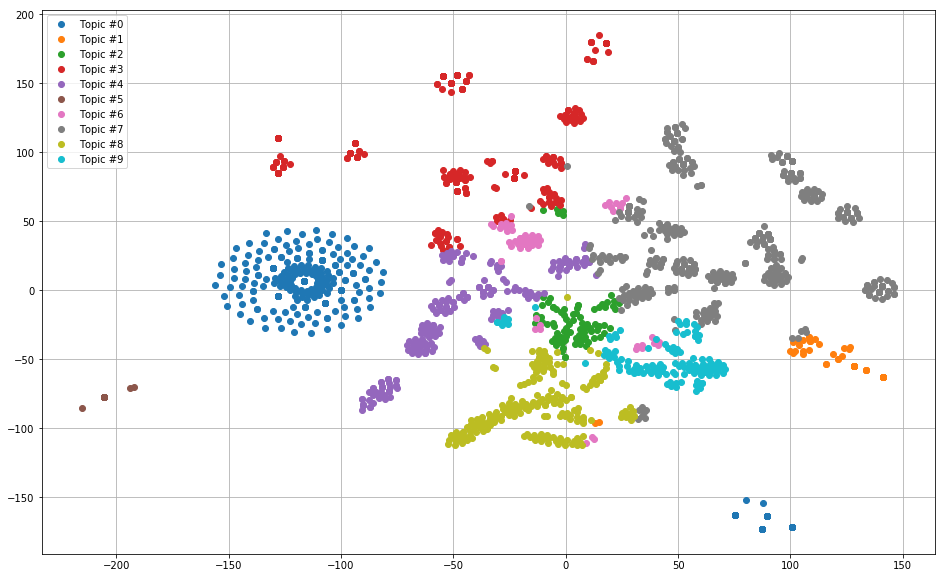

In [13]:
plt.figure(figsize=(16,10))
most_probable_topic = np.argmax(topic_proportions, axis=1)[:2000]
for t in range(10):  
    plt.plot(topic_tsne_lda[most_probable_topic==t,0], topic_tsne_lda[most_probable_topic==t,1], 'o',
             label="Topic #" + str(t))
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [18]:
topic_tsne_lda[:,0].shape

(2000,)

### Re-visualize the document-topic proportion matrix in 2-D using t-SNE [2.5 points]

   * Repeat the previous exercise, but colour the points based on their category.
   * Only plot apps in the top 10 most frequent categories.

You can now guess how your topics relate to the categories available in the app store. Some topics may correspond exactly to a specific category, while others may be a combination. Is there any topic (based on the plot above) that is very homogenous in its app categories? What is the topic and categories?

Index(['Sports', 'Arcade & Action', 'Education', 'Travel & Local',
       'Brain & Puzzle', 'Lifestyle', 'Books & Reference', 'Tools',
       'Personalization', 'Entertainment'],
      dtype='object', name='Category')


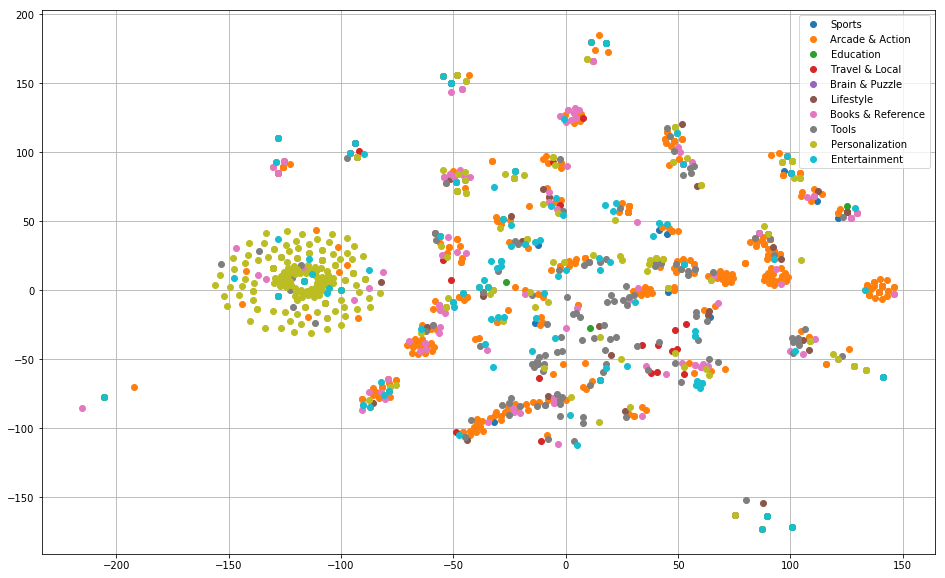

In [14]:
plt.figure(figsize=(16,10))
most_probable_topic = np.argmax(topic_proportions, axis=1)[:2000]
cats = df.groupby('Category')['Category'].count().sort_values().tail(n=10).index
print(cats)
for cat in cats:
    idx = (df['Category'] == cat)[:2000]
    plt.plot(topic_tsne_lda[idx,0], topic_tsne_lda[idx,1], 'o', label=cat)
plt.legend()
plt.grid()
plt.show()

### [Bonus] More insights. [2.5 points]

We have only touched the surface of this dataset; many more insights remain to be uncovered. Come up with more questions and *data-driven* answers to them. Some example questions:

   - What is the relationship between topics derived from the app descriptions and topics derived from their permissions? How can they be connected and compared?
   - Is the categorization that the Android app store provides adequate? Are the topics within a category homogenous? Can you suggest an alternate categorization?

### [Bonus] Malware [5 points]

This dataset contains Android app permissions labelled with whether they were malware or not: https://www.kaggle.com/xwolf12/datasetandroidpermissions

Could you visually identify (using topic modeling, t-SNE or other tools) how malware applications differ from benign ones? Use both datasets (the current one, and the one from Kaggle).